In [1]:
import sys
from pathlib import Path
project_root = Path.cwd().parents[0]
sys.path.append(str(project_root))
import pandas as pd
import numpy as np
from src import get_geoparse, get_enrichment_groups, fit_ols_df, fit_trajectories, plot_enrichment_dotplot, plot_compare_controls, plot_grouped_response_heatmap
import matplotlib.pyplot as plt
import asyncio

Parse in Data

In [2]:
expression_df, phenotype_df, gene_annot = get_geoparse()
phenotype_df["hours"] = (
    phenotype_df["title"]
    .str.extract(r"(\d+(?:\.\d+)?)\s*hours", expand=False)
    .astype(float)
)
phenotype_df["treated"] = ~phenotype_df["title"].str.contains(
    "negative control", case=False, na=False
)
phenotype_df = phenotype_df[['hours', 'treated']]

/Users/connorott/PycharmProjects/bioml/.venv/lib/python3.12/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")


Minimal Filtering:
    Only remove genes with pure background signal or low variance between samples

Genes after background filter: 46943
Genes after variance filter: 34552


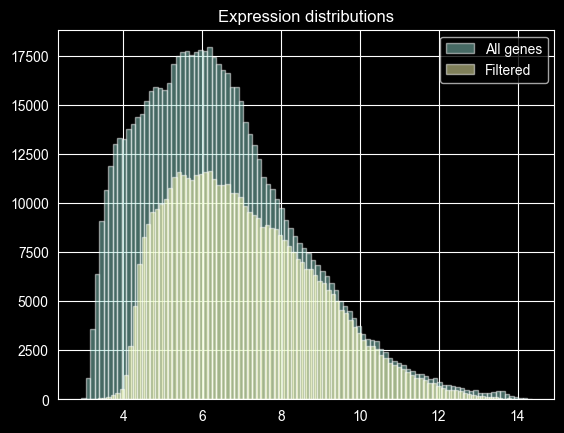

In [3]:
MIN_EXPR = 4.5  # background cutoff
background_filter = (expression_df > MIN_EXPR).any(axis=1)
exp_filter = expression_df.loc[background_filter]
print(f"Genes after background filter: {exp_filter.shape[0]}")

MIN_VAR = 0.01
var_filter = exp_filter.var(axis=1) > MIN_VAR
exp_filter = exp_filter.loc[var_filter]
print(f"Genes after variance filter: {exp_filter.shape[0]}")
plt.hist(expression_df.values.flatten(), bins=100, alpha=0.5, label="All genes")
plt.hist(exp_filter.values.flatten(), bins=100, alpha=0.5, label="Filtered")
plt.legend()
plt.title("Expression distributions")
plt.show()

Fit data to y~ B_int + B_time * T + B_treat * X + B_interaction * (T*X)

In [ ]:
samples = phenotype_df.index
if not set(samples).issubset(exp_filter.columns):
    missing = set(samples) - set(exp_filter.columns)
    raise ValueError(f"Samples in pheno missing from expr columns: {sorted(list(missing))[:10]} ...")
expr = exp_filter.loc[:, samples]

design_df = pd.DataFrame(index=phenotype_df.index)
design_df['time'] = phenotype_df['hours'] - phenotype_df['hours'].mean()
design_df['treatment'] = phenotype_df['treated'].astype(int)
design_df['treat_time'] = design_df['time'] * design_df['treatment']

names = ['treatment', 'treat_time']
results = fit_ols_df(design_df, expr, fdr=names)

Volcano Plots

In [ ]:
res = results.copy()
for c in names:
    res[('fdr', f'log_{c}')] = -np.log10(res[('fdr', c)] + 1e-300)
alpha = 0.05
sig_treat = res[('fdr', names[0])] < alpha
sig_int = res[('fdr', names[1])] < alpha
conditions = [
    (sig_treat & ~sig_int),   # only treatment
    (~sig_treat & sig_int),   # only interaction
    (sig_treat & sig_int),    # both
]
colors = ['red', 'blue', 'purple']
labels = ['Over Expression (Time Independent)', 'Over Expression (Time Dependent)', 'Both (Overlap)']
res['category'] = np.select(conditions, labels, default='Not significant')
color_map = {l: c for l, c in zip(labels, colors)}
color_map['Not significant'] = 'gray'
plot_colors = res['category'].map(color_map)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for ax, name in zip(axes.flat, names):
    ax.scatter(
        res[('beta', name)],
        res[('fdr', f'log_{name}')],
        s=10, alpha=0.6,
        c=plot_colors,
    )
    ax.axvline(0, color="black", lw=1)
    ax.axhline(-np.log10(0.05), color="red", ls="--", lw=1)
    ax.set_xlabel(f"beta_{name}")
    ax.set_ylabel("-log10(FDR)")
    ax.set_title(f"{name} effect")

handles = [plt.Line2D([0], [0], marker='o', color='w', label=lab,
                      markerfacecolor=col, markersize=10) for lab, col in color_map.items()]
axes[0].legend(handles=handles, loc='upper left', frameon=True)
plt.tight_layout()
plt.show()

In [ ]:
fdr = results['fdr']

hits = results[(fdr['treatment'] < 0.05) | (fdr['treat_time'] < 0.05)].sort_values(by=[('fdr', 'treat_time'), ('fdr', 'treatment')])
time_independent = results[(fdr['treatment'] < 0.05) & (fdr['treat_time'] >= 0.05)].sort_values(by=('fdr', 'treatment'))
time_dependent = results[(fdr['treat_time'] < 0.05) & (fdr['treatment'] >= 0.05)].sort_values(by=('fdr', 'treat_time'))
both = results[(fdr['treatment'] < 0.05) & (fdr['treat_time'] < 0.05)].sort_values(by=[('fdr', 'treat_time'), ('fdr', 'treatment')])

print(f"Total responsive genes: {len(hits)}")
print(f"Time Independent only: {len(time_independent)}")
print(f"Time Dependent only: {len(time_dependent)}")
print(f"Both: {len(both)}")

plot_compare_controls(phenotype_df, exp_filter, time_dependent.index, title='Time Dependent Affects')
plot_compare_controls(phenotype_df, exp_filter, time_independent.index, title='Time Independent Affects')


Split Interaction into response type categories
    Plot heatmap to view sorting algorithm efficacy

In [ ]:
samples = phenotype_df[phenotype_df['treated']].index
time = phenotype_df[phenotype_df['treated']]['hours']
interaction = results[results[('fdr', 'treat_time')] < 0.05]
all_time_dependent = exp_filter.loc[interaction.index, samples]

popts = fit_trajectories(all_time_dependent, time)

def group_trajectories(s):
    direction = np.sign(s['lin_slope'])
    r2_improvement = s['r2_quad'] - s['r2_linear']
    if r2_improvement > 0.05 and s['quad_importance'] > 0.1:
        if direction * s['q_c'] < 0:
            response = "early_response"
        else:
            response = "late_response"
    else:
        response = "sustained_linear"
    return pd.Series({'Direction':  f'{'positive' if direction>0 else 'negative'} response', 'Type': response})

interaction_traj_groups = popts.apply(group_trajectories, axis=1)
plot_grouped_response_heatmap(all_time_dependent, interaction_traj_groups, phenotype_df[['hours']])

Finalize Deliverables

In [ ]:
final_main = main_only[['fdr_treat', 'fdr_interaction']].copy()
final_main['response_class'] = 'treatment'
final_interaction = interaction[['fdr_interaction', 'fdr_treat']].copy()
final_interaction['response_class'] = interaction_traj_groups['response']
final = pd.concat([final_main, final_interaction], axis=0)
supp = popts[['lin_slope', 'peak_time']].copy()
supp['response_class'] = interaction_traj_groups['response']
supp['direction'] = interaction_traj_groups['direction']

In [ ]:
gene_map = gene_annot.set_index('ID')['Gene Symbol']
gene_map = hits.index.to_series().map(gene_map).str.split(r' /// ').str[0]

all_groups = interaction_traj_groups.apply(lambda g: f'{g['Direction']}_{g['Type']}', axis=1)
all_groups = pd.concat([all_groups, pd.Series(data='Time Independent', index=time_independent.index)])
groups = {g: gene_map.loc[all_groups.index[all_groups == g]].dropna().tolist() for g in all_groups.unique()}

enr_results = asyncio.run(get_enrichment_groups(groups))
plot_enrichment_dotplot(enr_results)


Analysis:
    Strong overlap with ribosomal rna. Ignore corona virus as overlap
    Over expression causes a fast decrease in ribosomal rna.
    Protein synthesis begins to shut down as miR-124 signals a neuron to mature and stop their high protein production.
    Downregulation of inflammatory pathways and Actin/RhoGTPase machinery affect infection pathways (shigellosis, salmonella, etc.)
    Upregulation of p53 pathway to signal cell cycle arrest for cellular maturation.

